# Plot GFM flood scene

This tutorial will show how to plot a part of a flooded GFM scene using an
OpenStreetMap basemap as background.

In [1]:
from pystac_client import Client
from datetime import datetime
from odc import stac as odc_stac
import pyproj
import rioxarray # noqa
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx

In [2]:
# Method to derive the sensing date from a Sentinel-1 scene identifier
def get_sensing_date(scene:str) -> datetime:
    parts = scene.split("_")
    return datetime.strptime(parts[4], "%Y%m%dT%H%M%S")

In [3]:
# Define Sentinel-1 scene identifier and asset name to plot
scene_id = "S1A_IW_GRDH_1SDV_20220930T224602_20220930T224627_045240_056863"
asset_name = "ensemble_flood_extent"

api_url = "https://stac.eodc.eu/api/v1"
eodc_catalog = Client.open(api_url)

search = eodc_catalog.search(
    collections=["GFM"],
    datetime=get_sensing_date(scene_id),
)

print("We found", search.matched(), "items, that match our filter criteria.")

We found 2 items, that match our filter criteria.


In [4]:
# Get found STAC items
items = search.item_collection()

# Retrieve the CRS from the first found STAC item
crs = pyproj.CRS.from_wkt(items[0].properties["proj:wkt2"])

# Load data of selected asset
data = odc_stac.load(
    items, 
    crs=crs,
    bands=[asset_name],
    resolution=20,
    dtype='uint8',
    )

# Get rid of single time axis
data = data[asset_name].squeeze() 


In [5]:
# Find min/max of valid flood data
mask = data == 1
indices = np.argwhere(mask.values)
minx, maxx = np.min(indices[:, 0]), np.max(indices[:, 0])
miny, maxy = np.min(indices[:, 1]), np.max(indices[:, 1])

data = data[minx:maxx, miny:maxy]

# Reproject data to "WebMercator" to be able to plot on a basemap
reproj_data = data.rio.reproject("EPSG:3857")
reproj_data = reproj_data.where((reproj_data == 1)).astype("float16")


In [8]:
# Reduce spatial extent due to memory constraints
plot_data = reproj_data[0:5000,0:5000]

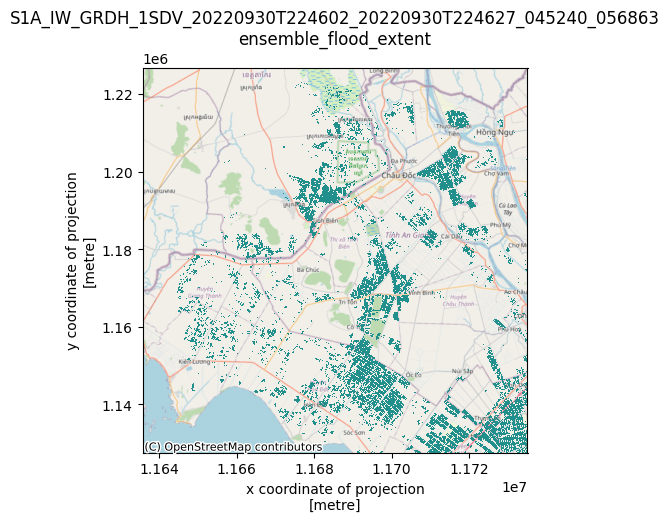

In [7]:

# Plot data and add basemap
ax = plot_data.plot(figsize=(5, 5), label="Flood", add_colorbar=False)

cx.add_basemap(ax.axes, crs='EPSG:3857', source=cx.providers.OpenStreetMap.Mapnik)

plt.title(f"{scene_id}\n{asset_name}")

plt.show()